Loading and splitting data...
Data loading complete.
Building preprocessor pipeline...

Processing model: LGBMClassifier
Fitting model without tuning...
X_train shape: (1458, 10)
Evaluating model on Training data...

Training Set Evaluation:
Accuracy: 0.6831
Confusion Matrix (raw):
[[  0  52   4   0]
 [  0 863  31   7]
 [  0 262  86  37]
 [  0  69   0  47]]


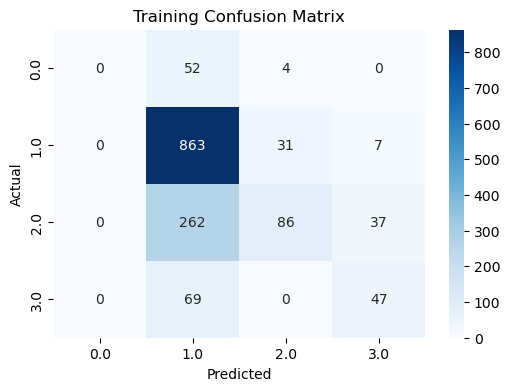

ROC-AUC (OVR): 0.8693

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        56
         1.0       0.69      0.96      0.80       901
         2.0       0.71      0.22      0.34       385
         3.0       0.52      0.41      0.45       116

    accuracy                           0.68      1458
   macro avg       0.48      0.40      0.40      1458
weighted avg       0.66      0.68      0.62      1458

Evaluating model on Test data...

Test Set Evaluation:
Accuracy: 0.6161
Confusion Matrix (raw):
[[  0  17   7   0]
 [  0 180   2  50]
 [  0  24  27   0]
 [  0  29   0   0]]


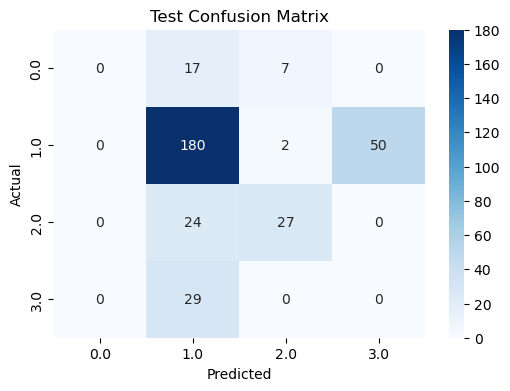

ROC-AUC (OVR): 0.5409

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        24
         1.0       0.72      0.78      0.75       232
         2.0       0.75      0.53      0.62        51
         3.0       0.00      0.00      0.00        29

    accuracy                           0.62       336
   macro avg       0.37      0.33      0.34       336
weighted avg       0.61      0.62      0.61       336

Plotting SHAP values for the fitted model...
Computing SHAP values...


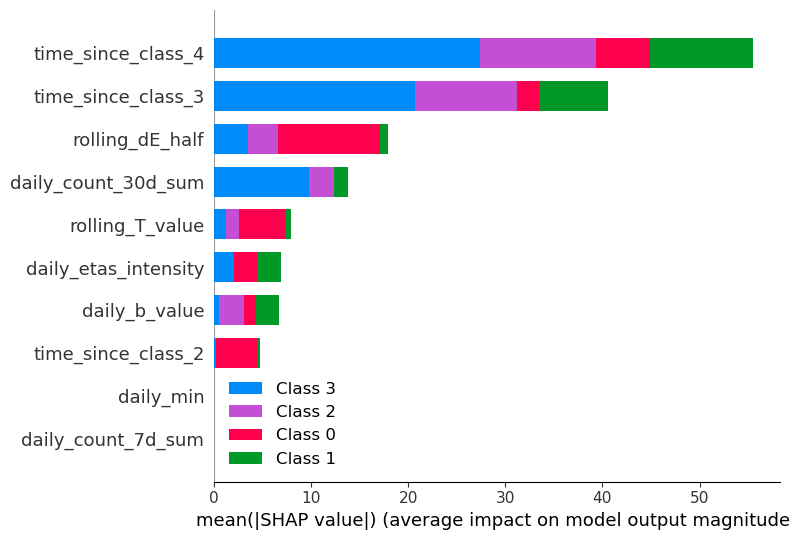

In [9]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import shap  # Import SHAP for model explainability
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report)

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# =============================================================================
# FUNCTIONS
# =============================================================================

def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train-test split.
    """
    print("Loading and splitting data...")
    df = pd.read_parquet(path)
    df = df.drop(columns=["magnitudes_list"])
    
    # Drop rows with missing target values
    if task == "regression":
        df = df.dropna(subset=["max_mag_next_30d"])
    else:
        df = df.dropna(subset=["target_class"])
    
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)
    
    # Select target column based on task
    target_col = "max_mag_next_30d" if task == "regression" else "target_class"
    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df[target_col]
    
    # For classification, shift labels to start at 0
    if task == "classification":
        y = y - 1
    
    # Temporal train-test split:
    #   Train: dates before 2024-01-01
    #   Test: dates from 2024-01-30 onward
    X_train = X.loc[X.date < "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date < "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()
    
    # Drop the date column since it's no longer needed
    X_train = X_train.drop(columns=["date"])
    X_test  = X_test.drop(columns=["date"])
    
    print("Data loading complete.")
    return X_train, X_test, y_train, y_test

def build_preprocessor():
    """
    Build a preprocessing pipeline with median imputation and standard scaling.
    """
    print("Building preprocessor pipeline...")
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    """
    Given a model name and task, return the model instance and its hyperparameter grid.
    """
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(n_estimators=1000,
                                 learning_rate=0.01,
                                 max_depth=3,
                                 min_child_weight=10,
                                 gamma=0.5,
                                 subsample=0.7,
                                 colsample_bytree=0.7,
                                 reg_lambda=10,
                                 reg_alpha=1,
                                 random_state=42)
            param_grid = {
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.01, 0.05],
                'model__min_child_weight': [10, 20]
            }
        elif model_name == "LGBMRegressor":
            model = LGBMRegressor(
                # **Tree Structure & Complexity Control**
                num_leaves=15,         # Lower value reduces model complexity (default: 31)
                max_depth=3,           # Limits tree depth (default: -1, unlimited)
                min_child_samples=50,  # Minimum number of data points per leaf (default: 20)

                # **Regularization (Bias-Variance Trade-off)**
                reg_alpha=0.5,         # L1 regularization (LASSO) for feature selection
                reg_lambda=0.5,        # L2 regularization (Ridge) for weight decay

                # **Feature & Data Sampling (Stochasticity)**
                colsample_bytree=0.8,  # Fraction of features used per tree (default: 1.0)
                subsample=0.8,         # Fraction of samples used per boosting round (default: 1.0)
                subsample_freq=1,      # Frequency of subsampling (0 means disabled)

                # **Boosting Control**
                learning_rate=0.1,     # Lower values add more bias, reducing overfitting (default: 0.1)
                n_estimators=200,      # Fewer trees prevent overfitting (default: 100)
                boosting_type='gbdt',  # Gradient Boosting Decision Trees (Options: 'dart', 'rf', 'gbdt')
                
                # **Early Stopping & Convergence**
                min_gain_to_split=0.01, # Minimum loss reduction required to split (default: 0.0)
                max_bin=255,           # Binning max value (higher improves precision but increases complexity)

                # **Categorical Feature Handling**
                cat_smooth=10,         # Smoothing for categorical features (prevents overfitting)
                
                # **Randomness & Reproducibility**
                random_state=42,       # Ensures reproducibility
                verbose=-1             # Suppresses excessive logs
            )

            # Expanded hyperparameter search space for LightGBM
            param_grid = {
                'model__num_leaves': [31, 50, 70, 90, 120],
                'model__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
                'model__max_depth': [-1, 5, 10, 15, 20],
                'model__min_child_samples': [10, 20, 30, 50],
                'model__subsample': [0.5, 0.7, 0.9, 1.0],
                'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
                'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
                'model__reg_lambda': [0, 0.01, 0.1, 1, 10]
            }
        elif model_name == "LinearRegression":
            model = LinearRegression()
            param_grid = {}
        elif model_name == "KNNRegressor":
            model = KNeighborsRegressor()
            param_grid = {
                'model__n_neighbors': [3, 5, 7]
            }
        elif model_name == "SVR":
            model = SVR()
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        elif model_name == "RandomForestRegressor":
            model = RandomForestRegressor(random_state=42)
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 5, 10]
            }
        else:
            raise ValueError(f"Invalid regression model name: {model_name}")
    else:
        if model_name == "XGBClassifier":
            num_class = len(np.unique(y_train)) if y_train is not None else 3
            model = XGBClassifier(n_estimators=500,
                                  learning_rate=0.05,
                                  max_depth=3,
                                  min_child_weight=10,
                                  gamma=0.5,
                                  subsample=0.7,
                                  colsample_bytree=0.7,
                                  reg_lambda=10,
                                  reg_alpha=1,
                                  objective="multi:softmax",
                                  num_class=num_class,
                                  random_state=42)
            param_grid = {
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.05, 0.1],
                'model__min_child_weight': [10, 20]
            }
        elif model_name == "LGBMClassifier":
            model = LGBMClassifier(
                # **Tree Structure & Complexity Control**
                num_leaves=10,         # Lower value reduces model complexity (default: 31)
                max_depth=2,           # Limits tree depth (default: -1, unlimited)
                min_child_samples=50,  # Minimum number of data points per leaf (default: 20)

                # **Regularization (Bias-Variance Trade-off)**
                reg_alpha=0.8,         # L1 regularization (LASSO) for feature selection
                reg_lambda=0.8,        # L2 regularization (Ridge) for weight decay

                # **Feature & Data Sampling (Stochasticity)**
                colsample_bytree=0.7,  # Fraction of features used per tree (default: 1.0)
                subsample=0.7,         # Fraction of samples used per boosting round (default: 1.0)
                subsample_freq=1,      # Frequency of subsampling (0 means disabled)

                # **Boosting Control**
                learning_rate=0.01,     # Lower values add more bias, reducing overfitting (default: 0.1)
                n_estimators=50,      # Fewer trees prevent overfitting (default: 100)
                boosting_type='rf',  # Gradient Boosting Decision Trees (Options: 'dart', 'rf', 'gbdt')
                
                # **Early Stopping & Convergence**
                min_gain_to_split=0.01, # Minimum loss reduction required to split (default: 0.0)
                max_bin=255,           # Binning max value (higher improves precision but increases complexity)

                # **Categorical Feature Handling**
                cat_smooth=10,         # Smoothing for categorical features (prevents overfitting)
                

                # **Probability Calibration**
                is_unbalance=True,     # Alternative to `class_weight` for handling imbalanced datasets

                # **Randomness & Reproducibility**
                random_state=42,       # Ensures reproducibility
                verbose=-1             # Suppresses excessive logs
            )
            # Expanded hyperparameter search space for LightGBM classifier
            param_grid = {
                'model__num_leaves': [15, 31, 50, 70, 100],
                'model__max_depth': [-1, 5, 10, 15, 20],
                'model__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
                'model__min_child_samples': [10, 20, 30, 50],
                'model__subsample': [0.5, 0.7, 0.9, 1.0],
                'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
                'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
                'model__reg_lambda': [0, 0.01, 0.1, 1, 10]
            }
        elif model_name == "LogisticRegression":
            model = LogisticRegression(max_iter=1000, random_state=42)
            param_grid = {
                'model__C': [0.1, 1, 10]
            }
        elif model_name == "KNNClassifier":
            model = KNeighborsClassifier()
            param_grid = {
                'model__n_neighbors': [3, 5, 7]
            }
        elif model_name == "SVC":
            model = SVC(probability=True, random_state=42, kernel='sigmoid')
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 5, 10]
            }
        else:
            raise ValueError(f"Invalid classification model name: {model_name}")
    return model, param_grid

def evaluate_model(model_pipeline: Pipeline, X, y, dataset: str, task: str):
    """
    Evaluate the given model pipeline on dataset (training or test), print performance metrics,
    and plot a heatmap of the confusion matrix for classification tasks.
    """
    print(f"Evaluating model on {dataset} data...")
    y_pred = model_pipeline.predict(X)
    print(f"\n{dataset} Set Evaluation:")
    if task == "regression":
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2  = r2_score(y, y_pred)
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")
    else:
        acc = accuracy_score(y, y_pred)
        cm  = confusion_matrix(y, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Confusion Matrix (raw):")
        print(cm)
        
        # Plot confusion matrix as a heatmap
        classes = np.unique(np.concatenate((y, y_pred)))
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{dataset} Confusion Matrix')
        plt.show()
        
        if hasattr(model_pipeline.named_steps['model'], "predict_proba"):
            y_proba = model_pipeline.predict_proba(X)
            try:
                roc_auc = roc_auc_score(y, y_proba, multi_class='ovr')
                print(f"ROC-AUC (OVR): {roc_auc:.4f}")
            except Exception as e:
                print("ROC-AUC calculation error:", e)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

def plot_shap_values(model_pipeline: Pipeline, X: pd.DataFrame, model_name: str):
    """
    Compute and plot SHAP values for tree-based models using TreeExplainer.
    This function transforms the input features using the pipeline's preprocessor.
    """
    print("Computing SHAP values...")
    # Retrieve the tree-based model from the pipeline
    tree_model = model_pipeline.named_steps['model']
    
    # Transform features using the preprocessor and create a DataFrame for clarity
    X_trans = model_pipeline.named_steps['preprocessor'].transform(X)
    X_trans_df = pd.DataFrame(X_trans, columns=X.columns)
    
    # Create a TreeExplainer and compute SHAP values
    explainer = shap.TreeExplainer(tree_model)
    shap_values = explainer.shap_values(X_trans_df)
    
    # Plot the summary SHAP values plot (tree-based plot)
    shap.summary_plot(shap_values, X_trans_df, plot_type='bar', max_display=10)


# =============================================================================
# PARAMETERS: Adjust these as needed
# =============================================================================

task = "classification"  # Options: "regression" or "classification"
do_tuning = False         # Set True to tune hyperparameters, False to just fit with initial parameters

# List the model names to test.
if task == "regression":
    selected_models = [
        "XGBRegressor", 
        # "LGBMRegressor", 
        # "LinearRegression", 
        # "KNNRegressor", 
        # "SVR", 
        # "RandomForestRegressor"
    ]
else:
    selected_models = [
        # "XGBClassifier", 
        "LGBMClassifier", 
        # "LogisticRegression", 
        # "KNNClassifier", 
        # "SVC", 
        # "RandomForestClassifier"
    ]


# Load and split the data
X_train, X_test, y_train, y_test = load_and_split_data("data/features/earthquake_features.parquet", task)

drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) + [col for col in X_train.columns if "list" in col]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

top_10_features = [
    "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
    "daily_count_30d_sum",
    "daily_b_value",
    "rolling_dE_half",
    "daily_etas_intensity",
    "time_since_class_2",
    "daily_min",
    "daily_count_7d_sum"
]

X_train = X_train[top_10_features]
X_test = X_test[top_10_features]

# Build preprocessor
preprocessor = build_preprocessor()

# Set up TimeSeriesSplit with fewer folds (3 instead of 5)
cv = TimeSeriesSplit(n_splits=3)

# Iterate over the selected models
for model_name in selected_models:
    print("\n" + "="*60)
    print(f"Processing model: {model_name}")
    
    # Get model instance and its hyperparameter grid
    model, param_grid = get_model_and_param_grid(model_name, task, y_train=y_train)
    
    # Build full pipeline with preprocessor and model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # If tuning is selected and a parameter grid is available, run RandomizedSearchCV.
    if do_tuning and param_grid:
        print("Tuning hyperparameters using RandomizedSearchCV with TimeSeriesSplit CV...")
        gs = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=cv,
                                scoring='accuracy' if task=="classification" else 'r2',
                                n_jobs=-1, verbose=3, n_iter=50, random_state=42)
        gs.fit(X_train, y_train)
        best_pipe = gs.best_estimator_
        print("Best Parameters:", gs.best_params_)
        # Display a summary of the top tuning iterations
        results_df = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
        print("\nCV Tuning Summary (Top 10 iterations):")
        print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))
    else:
        print("Fitting model without tuning...")
        best_pipe = pipe.fit(X_train, y_train)
    
    print("X_train shape:", X_train.shape)
    # Evaluate on the training set
    evaluate_model(best_pipe, X_train, y_train, dataset="Training", task=task)
    
    # Evaluate on the test set
    evaluate_model(best_pipe, X_test, y_test, dataset="Test", task=task)
    
    # Plot SHAP values (using training set data for explanation)
    print("Plotting SHAP values for the fitted model...")
    plot_shap_values(best_pipe, X_train, model_name)
    
    print("="*60 + "\n")


In [ ]:
from scipy.misc import derivative
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	p = 1/(1+np.exp(-y_pred))
	loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
	return 'focal_loss', np.mean(loss), False


focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1.)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 1.)
lgbtrain = lgb.Dataset(X_tr, y_tr, free_raw_data=True)
lgbeval = lgb.Dataset(X_val, y_val)
params  = {'learning_rate':0.1, 'num_boost_round':10}
model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], fobj=focal_loss, feval=eval_error )

Loading and splitting data...
Data loading complete.
Building preprocessor pipeline...
Number of classes: 4
Accuracy: 0.22321428571428573
Confusion Matrix:
[[11  2 11  0]
 [87 52 56 37]
 [24 15  6  6]
 [17  1  5  6]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.08      0.46      0.13        24
         1.0       0.74      0.22      0.34       232
         2.0       0.08      0.12      0.09        51
         3.0       0.12      0.21      0.15        29

    accuracy                           0.22       336
   macro avg       0.26      0.25      0.18       336
weighted avg       0.54      0.22      0.27       336



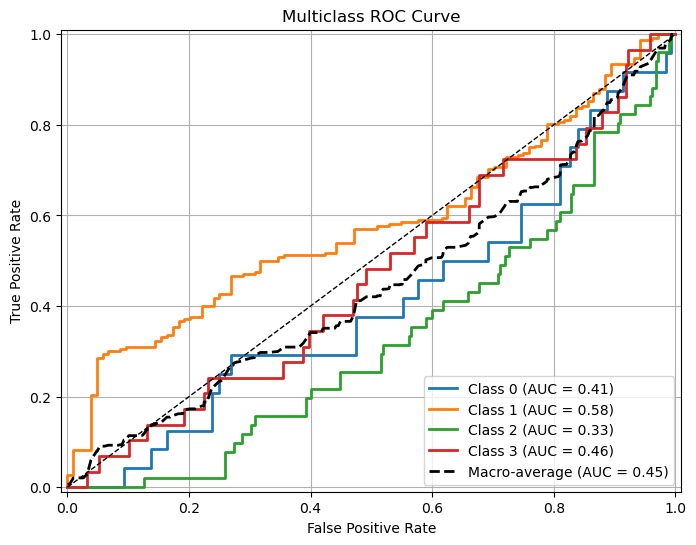

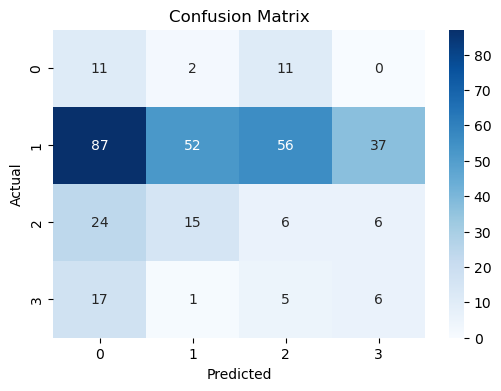

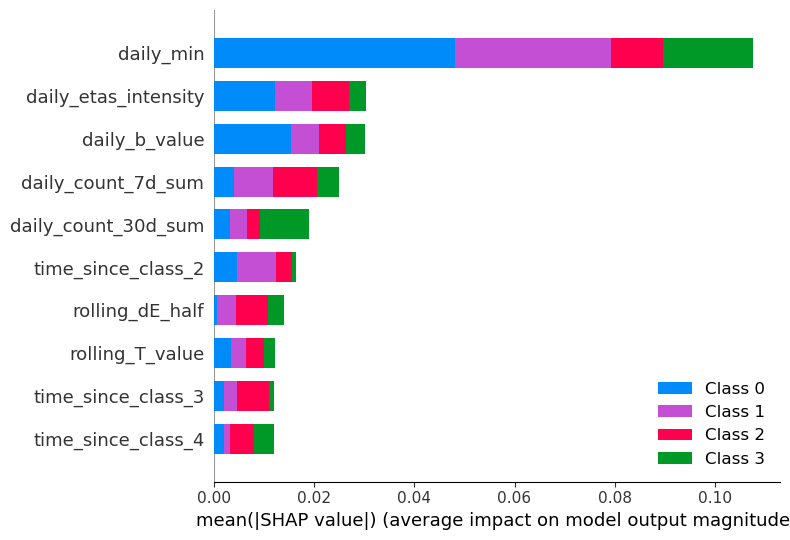

In [38]:
import pandas as pd
import numpy as np
import warnings

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

# ------------------ Custom Multiclass Focal Loss Functions ------------------
from scipy.misc import derivative

def focal_loss_lgb_multiclass(y_pred, dtrain, alpha, gamma):
    """
    Custom multiclass focal loss objective for LightGBM.
    Uses numerical finite differences to approximate gradients and Hessians.
    
    Parameters:
      y_pred: flat array of raw predictions (logits) of shape (n_samples * num_class,)
      dtrain: LightGBM Dataset, from which true labels are extracted via dtrain.get_label()
      alpha: weighting factor (e.g. 0.25)
      gamma: focusing parameter (e.g. 1)
      
    Returns:
      grad: flattened gradients (n_samples * num_class,)
      hess: flattened Hessians (n_samples * num_class,)
    """
    # Determine number of classes from the true labels.
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    # Reshape predictions to (n_samples, num_class)
    y_pred = y_pred.reshape(n_samples, num_class)
    
    # Initialize gradient and hessian arrays
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)
    eps = 1e-6  # finite difference step
    
    # For each sample, approximate partial derivatives for each class score
    for i in range(n_samples):
        for k in range(num_class):
            # Define a scalar function f that perturbs the k-th logit only
            def f(z):
                z_vec = y_pred[i].copy()
                z_vec[k] = z
                # Compute softmax probabilities
                exp_z = np.exp(z_vec - np.max(z_vec))
                p = exp_z / np.sum(exp_z)
                # Focal loss for this sample: only the true class term contributes.
                loss = -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
                return loss
            z0 = y_pred[i, k]
            # Central difference for first derivative
            grad[i, k] = (f(z0 + eps) - f(z0 - eps)) / (2 * eps)
            # Second derivative approximation
            hess[i, k] = (f(z0 + eps) - 2 * f(z0) + f(z0 - eps)) / (eps ** 2)
    
    return grad.reshape(-1), hess.reshape(-1)

def focal_loss_lgb_multiclass_eval(y_pred, dtrain, alpha, gamma):
    """
    Custom evaluation metric for multiclass focal loss.
    
    Returns:
      A tuple (metric_name, value, is_higher_better)
    """
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    y_pred = y_pred.reshape(n_samples, num_class)
    loss_sum = 0.0
    for i in range(n_samples):
        exp_z = np.exp(y_pred[i] - np.max(y_pred[i]))
        p = exp_z / np.sum(exp_z)
        loss_sum += -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
    return 'focal_loss', loss_sum / n_samples, False

# Lambdas wrapping our functions with alpha=0.25 and gamma=1.
focal_loss_multiclass = lambda y_pred, dtrain: focal_loss_lgb_multiclass(y_pred, dtrain, 1.0, 0.1)
focal_loss_multiclass_eval = lambda y_pred, dtrain: focal_loss_lgb_multiclass_eval(y_pred, dtrain, 1.0, 0.1)

# ------------------ Other Imports ------------------
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =============================================================================
# Data Loading & Preprocessing Functions
# =============================================================================

def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train-test split.
    """
    print("Loading and splitting data...")
    df = pd.read_parquet(path)
    df = df.drop(columns=["magnitudes_list"])
    
    if task == "regression":
        df = df.dropna(subset=["max_mag_next_30d"])
    else:
        df = df.dropna(subset=["target_class"])
    
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)
    
    target_col = "max_mag_next_30d" if task=="regression" else "target_class"
    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df[target_col]
    
    if task == "classification":
        y = y - 1  # shift labels so they start at 0
    
    # Temporal split: Train before 2024-01-01, Test from 2024-01-30 onward
    X_train = X.loc[X.date < "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date < "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()
    
    X_train = X_train.drop(columns=["date"])
    X_test  = X_test.drop(columns=["date"])
    
    print("Data loading complete.")
    return X_train, X_test, y_train, y_test

def build_preprocessor():
    """
    Build a preprocessing pipeline with median imputation and standard scaling.
    """
    print("Building preprocessor pipeline...")
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

# =============================================================================
# Main Script
# =============================================================================

# Set task to "classification" (multiclass)
task = "classification"

# Load and split data (adjust the path as needed)
X_train, X_test, y_train, y_test = load_and_split_data("data/features/earthquake_features.parquet", task)

# Drop columns with ≥50% missing values and any columns containing "list"
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) + [col for col in X_train.columns if "list" in col]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# Select top 10 features
top_10_features = [
    "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
    "daily_count_30d_sum",
    "daily_b_value",
    "rolling_dE_half",
    "daily_etas_intensity",
    "time_since_class_2",
    "daily_min",
    "daily_count_7d_sum"
]
X_train = X_train[top_10_features]
X_test = X_test[top_10_features]

# Build and apply preprocessor
preprocessor = build_preprocessor()
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# Create native LightGBM Datasets
lgb_train = lgb.Dataset(X_train_trans, label=y_train, free_raw_data=True)
lgb_eval  = lgb.Dataset(X_test_trans, label=y_test)

# Determine number of classes from training labels
num_class = int(np.max(y_train)) + 1
print("Number of classes:", num_class)

# Set training parameters (using your provided LGBMClassifier settings)
params = {
    # 'boosting_type': 'rf',         # Using RF boosting as in your classifier
    'num_leaves': 10,              # Lower value reduces model complexity
    'max_depth': 2,                # Limits tree depth
    'min_data_in_leaf': 50,        # Minimum number of data points per leaf
    'reg_alpha': 0.8,              # L1 regularization
    'reg_lambda': 0.8,             # L2 regularization
    'colsample_bytree': 0.7,       # Fraction of features used per tree
    'subsample': 0.7,              # Fraction of samples used per boosting round
    'subsample_freq': 1,           # Frequency of subsampling
    'learning_rate': 0.01,         # Lower learning rate to reduce overfitting
    'min_gain_to_split': 0.01,     # Minimum loss reduction required to split
    'max_bin': 255,                # Maximum bin value for discretizing features
    'cat_smooth': 10,              # Smoothing for categorical features
    'is_unbalance': True,          # Handle imbalanced datasets
    'seed': 42,                    # For reproducibility
    'verbose': -1,                 # Suppress logs
    'num_class': num_class,        # Number of classes for multiclass classification
    'objective': focal_loss_multiclass  # Custom focal loss objective
    # "objective": 'multiclass'
}
num_boost_round = 50  # Set n_estimators equivalent

# Train model using lgb.train with custom multiclass focal loss eval metric
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_eval],
                  num_boost_round=num_boost_round,
                #   feval=focal_loss_multiclass_eval
                  )

# Make predictions on the test set
# For multiclass, model.predict returns a flat array; reshape and take argmax.
y_pred_prob = model.predict(X_test_trans)
y_pred = np.argmax(y_pred_prob.reshape(-1, num_class), axis=1)

# Evaluate predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ------------------- ROC-AUC Plot for Multiclass -------------------

# Binarize the true labels for ROC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(num_class))
y_score = y_pred_prob  # shape: (n_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_class):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = sns.color_palette("tab10", num_class)
for i, color in zip(range(num_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot SHAP values for model explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values, X_test_trans, feature_names=top_10_features, plot_type='bar', max_display=10)



In [ ]:
lgb.train